<a href="https://colab.research.google.com/github/aigOffline/Deep-Learning/blob/master/residualblocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up the Environment

Note: Make sure to restart the runtime if installing the residualnets package for the first time

In [1]:
!rm -fr ResidualNets
!git clone https://github.com/rohin-dasari/ResidualNets.git
!cd ResidualNets && pip install -e . && cd ../

Cloning into 'ResidualNets'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 90 (delta 34), reused 73 (delta 17), pack-reused 0
Unpacking objects: 100% (90/90), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ResidualNets
  Running setup.py develop for residual


# Basic Example

In [74]:
pip install sranodec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
!cd ..


In [46]:
cd cifar-10-batches-py

/content/data/cifar-10-batches-py


In [55]:
cd ResidualNets


/content/ResidualNets


In [56]:
!ls

README.md  residual  residual.egg-info	setup.py  tests


In [73]:
ls

data/  ResidualNets/  resnets_utils.py  sample_data/


In [64]:
cd residual.egg-info

/content/ResidualNets/residual.egg-info


In [89]:
import torch
from torchsummary import summary
import residual

In [86]:
cd data/ResidualNets/resnets_utils.py/sample_data

[Errno 2] No such file or directory: 'data/ResidualNets/resnets_utils.py/sample_data'
/content


In [91]:
resnet18_config = [ residual.ResidualConfig(channels=64, conv_kernel_size=3, skip_kernel_size=1),
  residual.ResidualConfig(channels=128, conv_kernel_size=3, skip_kernel_size=1, stride=2),
  residual.ResidualConfig(channels=256, conv_kernel_size=3, skip_kernel_size=1),
  residual.ResidualConfig(channels=256, conv_kernel_size=3, skip_kernel_size=1),
  residual.ResidualConfig(channels=512, conv_kernel_size=3, skip_kernel_size=1)
]

data_shape = (1, 3, 32, 32) # shape of a single record

data = torch.randn((32, 3, 32, 32))
out_shape = 10

resnet18 = residual.ResNet(data_shape, out_shape, configs=resnet18_config, device='cuda')
data = data.to('cuda')
outputs = resnet18.forward(data)

# Loading the Dataset

In [92]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


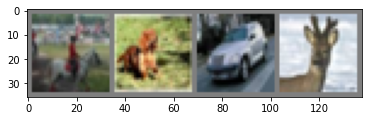

horse dog   car   deer 
tensor([7, 5, 1, 4])


In [93]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(labels)

# Defining the Model

In [95]:
resnet18_config = [
  residual.ResidualConfig(channels=64, conv_kernel_size=3, skip_kernel_size=1),
  residual.ResidualConfig(channels=128, conv_kernel_size=3, skip_kernel_size=1, stride=2),
  residual.ResidualConfig(channels=256, conv_kernel_size=3, skip_kernel_size=1),
  residual.ResidualConfig(channels=256, conv_kernel_size=3, skip_kernel_size=1),
  residual.ResidualConfig(channels=512, conv_kernel_size=3, skip_kernel_size=1)
]

data_shape = (1, *images[0].shape)
outputs = len(classes)
resnet18 = residual.ResNet(data_shape, outputs, configs=resnet18_config)
# resnet18 = resnet18.to('cuda')

# Training the Model

In [110]:
import torch.optim as optim
import torch
import torch.nn as nn


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model = model.to(device)
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        #y_pred, _ = model(x)
        y_pred = model(x)

        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
  
  epoch_loss = 0
  epoch_acc = 0

  model = model.to(device)
  model.eval()
  
  with torch.no_grad():
      
      for (x, y) in iterator:

          x = x.to(device)
          y = y.to(device)

          #y_pred, _ = model(x)
          y_pred = model(x)

          loss = criterion(y_pred, y)

          acc = calculate_accuracy(y_pred, y)

          epoch_loss += loss.item()
          epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

optimizer = optim.Adam(resnet18.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
# resnet18.to(device)

EPOCHS = 1
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
  train_loss, train_acc = train(resnet18, trainloader, optimizer, criterion, device)
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  val_loss, val_acc = evaluate(resnet18, testloader, criterion, device)
  val_losses.append(val_acc)
  val_accs.append(val_acc)

  # save the model
  torch.save(resnet18, f'model-{epoch}.pt')

  # print metrics
  print(f'train loss: {train_loss}, train accuracy: {train_acc}, validation loss: {val_loss}, validation accuracy: {val_acc}')

train loss: 1.4035003280806542, train accuracy: 0.47548, validation loss: 1.2198710759758948, validation accuracy: 0.557


# Model Summaries

In [116]:
resnet18 = residual.ResNet(data_shape, out_shape, configs=resnet18_config, device='cuda')
data = data.to('cuda')
outputs = resnet18.forward(data)

In [117]:
summary(resnet18, input_size=(3, 100, 100))

RuntimeError: ignored

In [118]:
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights)
model.to('cuda')
summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,